In [1]:
# Install needed pip package in the current Jupyter kernel the right way
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/#How-to-use-Pip-from-the-Jupyter-Notebook
import sys
!{sys.executable} -m pip install flipper-raw-rfid matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


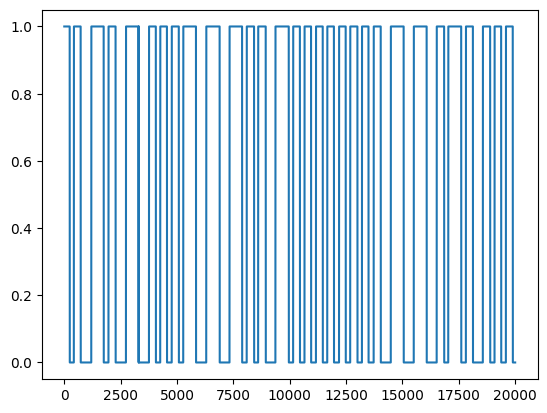

In [2]:
from flipper_raw_rfid import RiflFile, pad_to_signal, autocorrelate, smooth, binarize
from matplotlib import pyplot as plt
from scipy import signal as scipy_signal

# Basic usage

rifl = RiflFile.load('../tests/assets/Red354.ask.raw')

# Get the signal as pulse length and duration length meaured in samples
pad = rifl.pulse_and_durations()
# Convert it into something more standard (vector of 0 and 1) 
signal = pad_to_signal(pad)
    
plt.plot(signal[:20000])

# Yeah looks like a signal

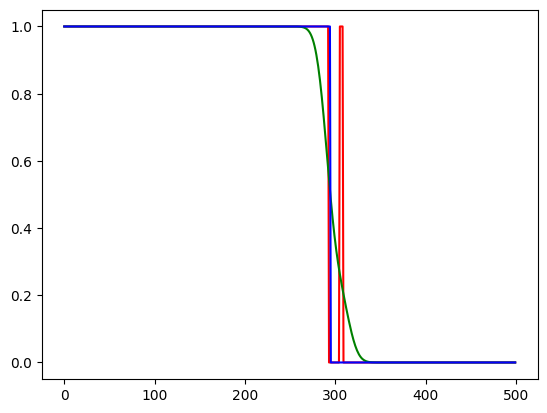

In [3]:
# Optionally fix some too short pulses..
#
# Why is the stroke at around 3000 so thick? (in red)
plt.plot(signal[3000:3500], 'r')

# Looks like very short pulse more probably a reading error
# We gonna blur the signal a bit (in green)
smooth_signal = smooth(signal, sigma=10)
plt.plot(smooth_signal[3000:3500], 'g')

# And binarize it again to get rid of the error
fixed_signal = binarize(smooth_signal, threshold=0.5)
plt.plot(fixed_signal[3000:3500],'b')

# Nice

array([ 32708,  65416,  98124, 130832, 163540, 196248, 228956, 261665,
       294372, 327080, 359788, 392496])

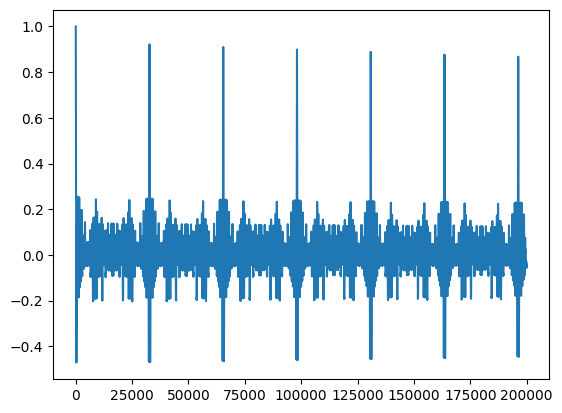

In [4]:
# If it is a real signal there should be some repetition in it
# it gets send several times, so we assume it will hava a correlation with itself
signal_autocorrelation = autocorrelate(fixed_signal)
plt.plot(signal_autocorrelation[:200000])

peaks, _ = scipy_signal.find_peaks(signal_autocorrelation, height=0.8, prominence=1)
peaks
# There are peaks at 32708 and more or less multiples of it, looks good

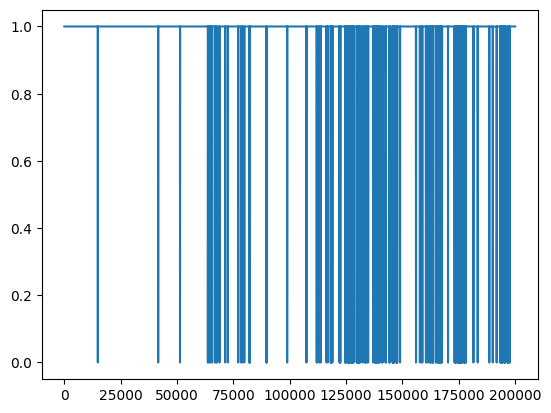

In [5]:
# Lets compare it to when there is no data in the file
no_signal = RiflFile.load('../tests/assets/Nothing.ask.raw').signal()

# Looks strange
plt.plot(no_signal[:200000])


array([], dtype=int64)

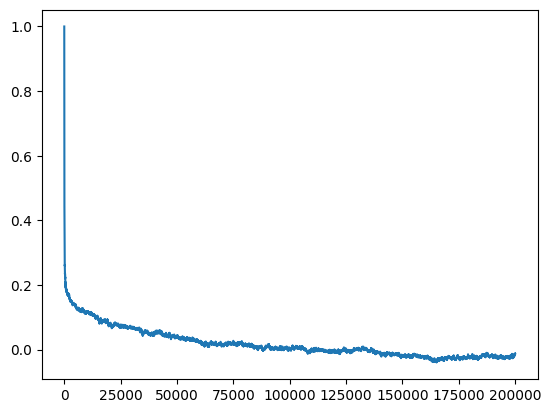

In [9]:
# And has absolutely no peaks in the autocorrelation
no_signal_autocorrelation = autocorrelate(no_signal)
plt.plot(no_signal_autocorrelation[:200000])

peaks, _ = scipy_signal.find_peaks(no_signal_autocorrelation, height=0.8, prominence=1)
peaks

# No peaks

In [7]:
# To be continued